**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Imports and set magics:

In [1]:
# Import modules
import sympy as sm
import numpy as np
import random
from scipy import optimize
import matplotlib.pyplot as plt
import warnings

# Autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Predefine options for all plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 10})


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)

Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor

The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

To verify the optimal labor supply choice given net wages, I use `SymPy`. <br>
Since `SumPy` cannot create the tilde symbol for net wages, I use $\varpi$.

In [2]:
# Create SymPy symbols for the variables and parameters
C, G, L, alpha, nu, kappa, tau, w, varpi = sm.symbols('C, G, L, alpha, nu, kappa, tau, w, varpi')

# Set the utility function
utility_func = sm.log(C**alpha * G**(1-alpha)) - nu * L**2 / 2

# Set consumption function with net wages [(1 - tau) * w] as varpi
consumption_func = kappa + varpi * L

# Substitute the consumption function into C in the utility function
utility_func = utility_func.subs(C, consumption_func)

# Find the derivate of the utility function w.r.t. L
derivative_of_utility_func = sm.diff(utility_func, L)

# Solve the derivative equal to zero for L
optimal_labor = sm.solve(derivative_of_utility_func, L)

# Since labor has to be larger than or equal than zero
optimal_labor = optimal_labor[1]

# Display
optimal_labor

(-kappa*nu + sqrt(nu*(4*alpha*varpi**2 + kappa**2*nu)))/(2*nu*varpi)

Since `SymPy` cannot simplify any further, I do the last bit of simplification:

$$
\begin{align*}
\frac{{-k\nu + \sqrt{{v(\kappa^2 \nu + 4\alpha\varpi^2)}}}}{{2\nu\varpi}} = \frac{{-k + \sqrt{{\frac{{\kappa^2 \nu + 4\alpha\varpi^2}}{{\nu}}}}}}{{2\varpi}} = \frac{{-k + \sqrt{{\kappa^2 + 4\frac{{\alpha}}{{\nu}}\varpi^2}}}}{{2\varpi}}
\end{align*}
$$

Q.E.D.

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

To illustrate how optimal labor supply depends on wages, I set parameters and a grid of wages, create a function for optimal labor, run the function for a range of wages and save the results. Lastly, I plot the results for a vector of wages.

Set parameters and grid of wages:

In [3]:
# Set parameters
alpha_val = 0.5
kappa_val = 1.0
nu_val = 1 / (2 * 16**2)
tau_val = 0.30
w_val = 1.0

# Set grid of wages
w_vals = np.linspace(0.1, 5, 100)

Create a function for optimal labor and save the results:

In [4]:
# Create function for optimal labor given the parameters
def optimal_labor_func(alpha, kappa, nu, tau, w):
    return (-kappa + np.sqrt(kappa**2 + 4 * (alpha / nu) * ((1 - tau) * w)**2)) / (2 * ((1 - tau) * w))

# Run the function for a range of wages and save the results
optimal_labor_values = optimal_labor_func(alpha_val, kappa_val, nu_val, tau_val, w_vals)

Plot the results:

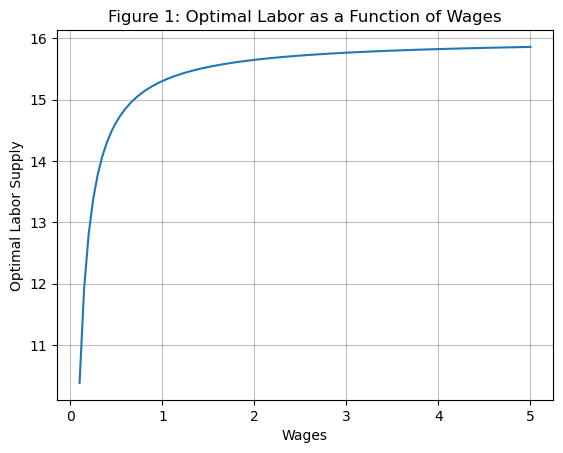

In [5]:
# Plot the function
# Create a figure
fig = plt.figure()

# Set x- and y-axis
ax = fig.add_subplot(1,1,1)
ax.plot(w_vals,optimal_labor_values)

# Set title, x- and y-label. 
ax.set_title('Figure 1: Optimal Labor as a Function of Wages')
ax.set_xlabel('Wages')
ax.set_ylabel('Optimal Labor Supply');

# Display plot
plt.show();

Figure 1 illustrates that optimal labor rises with wages. Initially, there is a sharp increase in labor hours as wages increase. However, the marginal utility gained from higher wages diminishes significantly beyond a certain point, causing a positive and decreasing slope. The decrease may be interpreted as workers placing an incrementally higher value on leisure as their earnings and working hours increase.


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


Set parameters, a grid of tax rates, and initialize empty lists:

In [6]:
# Set parameters
alpha_val = 0.5
kappa_val = 1.0
nu_val = 1 / (2 * 16**2)
tau_val = 0.3
w_val = 1.0

# Set grid of tax rates
tau_vals = np.linspace(0, 1, 100)

# Initialize empty lists
L_star_vals = []
G_vals = []
V_vals = []

Create a function to find implied $L, G$ and $V$:

In [7]:
# Create a function to find the implied L, G and V
def implied_L_G_V(alpha, kappa, nu, tau, w):
    L_star = optimal_labor_func(alpha, kappa, nu, tau, w)

    # Calculate goverment consumption
    G = tau * w * L_star

    # Calculate private consumption
    C = kappa + (1 - tau) * w * L_star

    # Calculate utility
    V = np.log(C**alpha * G**(1 - alpha)) - nu * (L_star**2 / 2)

    return L_star, G, V

Calculate the implied values given the values of $\tau$:

In [8]:
# Calculate implied_L_G_V for the values of tau
for tau in tau_vals:

    # Ignore warnings once
    warnings.filterwarnings('ignore')

    # Call the function implied_L_G_V
    L_star, G, V = implied_L_G_V(alpha_val, kappa_val, nu_val, tau, w_val)

    # Store results
    L_star_vals.append(L_star)
    G_vals.append(G)
    V_vals.append(V)


Plot the results:

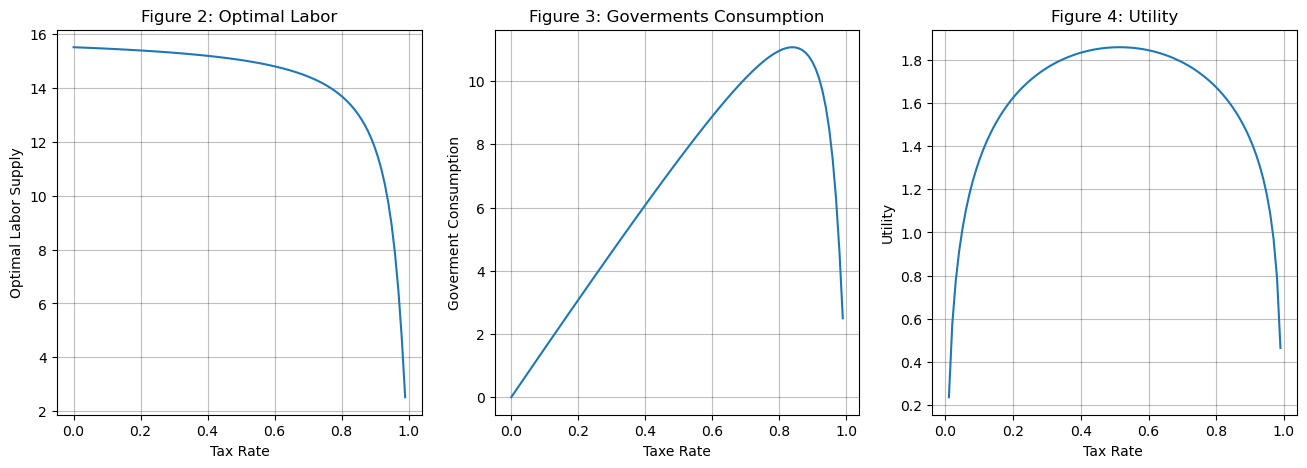

In [9]:
# Plot the implied functions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

## Figure 1
# Set x- and y-axis
ax1.plot(tau_vals, L_star_vals)

# Set title, x- and y-label. 
ax1.set_title('Figure 2: Optimal Labor')
ax1.set_xlabel('Tax Rate')
ax1.set_ylabel('Optimal Labor Supply')

## Figure 2
# Set x- and y-axis
ax2.plot(tau_vals, G_vals)

# Set title, x- and y-label. 
ax2.set_title('Figure 3: Goverments Consumption')
ax2.set_xlabel('Taxe Rate')
ax2.set_ylabel('Goverment Consumption')

## Figure 3
# Set x- and y-axis
ax3.plot(tau_vals, V_vals)

# Set title, x- and y-label. 
ax3.set_title('Figure 4: Utility')
ax3.set_xlabel('Tax Rate ')
ax3.set_ylabel('Utility')

# Display plot
plt.show();

Figure 2 illustrates that the optimal labor decreases as the tax rate increases, a correlation in line with intuition, as lower net wages often result in reduced work effort. Figure 3 shows that government consumption rises concerning increasing tax rates, which is logical given that the consumption function utilizes all available revenue. However, there's a critical point where government consumption significantly decreases due to the falling labor supply.
Further examination of Figure 4 indicates an initial rise in worker utility in correlation with tax increases up to a certain threshold. Beyond this point, a sharp decline in worker utility aligns well with $alpha = 0.5$.

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

To find the tax rate that maximizes worker utility, I create an objective function that calculates utility as function $\tau$ and use `SciPy.Optimize` to find an optimal solution. 

In [10]:
# Create an objective function which calculates negative utility as a function of tau
def objective(tau):
    L_star, G, V = implied_L_G_V(alpha_val, kappa_val, nu_val, tau, w_val)
    return -V

# Set initial guess
initial_guess = 0.5

# Set bounds
bounds = [(0.3, 0.7)]

# Call solver
sol = optimize.minimize(fun = objective, x0 = initial_guess, bounds = bounds)

# Print solution
print(f"Tax rate :{sol.x[0]:.3f}, Utility:{-sol.fun:.3f}")


Tax rate :0.515, Utility:1.859


I illustrate the result.

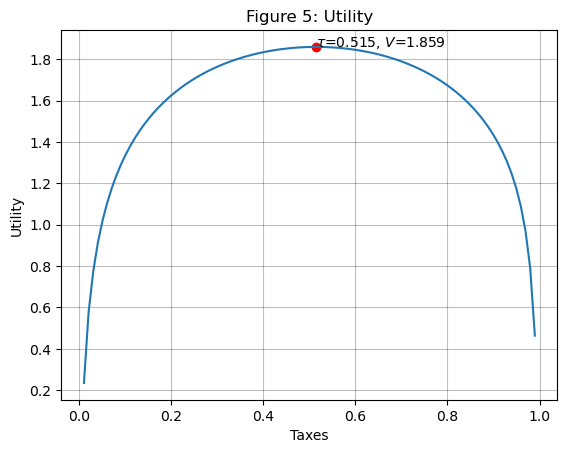

In [11]:
# Create a figure
fig = plt.figure()

# Set x- and y-axis
ax = fig.add_subplot(1,1,1)
ax.plot(tau_vals, V_vals)

# Set title, x- and y-label. 
ax.set_title('Figure 5: Utility')
ax.set_xlabel('Taxes')
ax.set_ylabel('Utility')

# Plot a single point
ax.scatter(sol.x, -sol.fun, color="red")

# Add text to the point
ax.text(sol.x, -sol.fun, fr'$\tau$={sol.x[0]:.3f}, $V$={-sol.fun:.3f}', fontsize=10)

# Display plot
plt.show();


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

Set parameters:

In [12]:
# Set parameters
eta = 0.5
w  = 1.0
kappa_vals = [1.0, 2.0]

Create functions to calculate profits and profit-maximizing labor. 

In [13]:
# Create function to calculate profits
def negative_profit(l, kappa, eta, w):
    return - (kappa * l**(1 - eta) - w * l)

# Create function to calculate profit-maximizing labor
def labor(kappa, eta, w):
    return (((1 - eta) * kappa) / w)**(1 / eta)

I solve the profit function for labor using `SciPy.minimize`.

In [14]:
# Create dictionaries to store solutions
l = {}
sol = {}

for i, kappa in enumerate(kappa_vals):
    # Calculate labor given the formula 
    l[i] = labor(kappa_vals[i], eta, w)

    # Create an initial guess
    initial_guess = 0.5

    # Set bounds
    bounds = [(0.1, 2)]

    # Optimize negative_profit for l
    sol[i] = optimize.minimize(fun = negative_profit, x0 = initial_guess, bounds = bounds, args = (kappa_vals[i], eta, w))

    # Print solutions
    print(f"For kappa = {kappa}, maximum profit is achieved at l = {sol[i].x}")
    print(f"The formula suggests that the profit-maximizing value of labor is {l[i]}")

For kappa = 1.0, maximum profit is achieved at l = [0.2500044]
The formula suggests that the profit-maximizing value of labor is 0.25
For kappa = 2.0, maximum profit is achieved at l = [0.99999988]
The formula suggests that the profit-maximizing value of labor is 1.0


The analytical and numerical values are very close to each other; thus, I can verify that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximizes profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.
<br>
<br>

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

Set parameters:

In [15]:
# Set parameters
eta = 0.5
w  = 1.0

rho = 0.90
iota = 0.01

sigma = 0.10
R = (1 + 0.01)**(1 / 12)

t = 120
K = 10000

Define functions:

In [16]:
def demand_shock(rho, sigma, t):
    # Initialize an array to store values of log_kappa
    log_kappa = np.zeros(t)

    # Set log_kappa for t = 0
    log_kappa[0] = np.log(1)

    # Calculate epsilon
    epsilon = np.random.normal(-0.5 * sigma**2, sigma, size=t)

    # Calculate log_kappa
    for i in range(1, t):
        log_kappa[i] = rho * log_kappa[i-1] + epsilon[i]

    # Return kappa instead of log_kappa
    kappa = np.exp(log_kappa)

    return kappa

def workers(kappa, eta, w, t):
    # Initialize an array to store values of l
    l = np.zeros(t)

    # Set l for t = 0 
    l[0] = 0

    # Calculate l
    for i in range(1, t):
        l[i] = (((1 - eta) * kappa[i]) / w)**(1 / eta)

    return l

def post_value(kappa, eta, w, R, iota, t):
    # Initialize an array to store values of h
    hs = np.zeros(t)

    # Call workers for l
    l = workers(kappa, eta, w, t)

    # Calculate h
    for i in range(0, t):
        if l[i] != l[i-1]:
            hs[i] = R**(-i) * (kappa[i] * l[i]**(1-eta) - w * l[i] - iota)
        else:
            hs[i] = R**(-i) * (kappa[i] * l[i]**(1-eta) - w * l[i])

    # Sum up all h
    h = np.sum(hs)

    return h

def ante_value(rho, sigma, eta, w, R, iota, t, K):
    # Initialize an array to store values of h
    Hs = np.zeros(K)

    for k in range(0, K):
        # Call demand_shock for kappa
        kappa = demand_shock(rho, sigma, t)
        Hs[k] = post_value(kappa, eta, w, R, iota, t)

    # Calculate mean of Hs
    H = np.mean(Hs)

    return H


Solve for $H$:

In [17]:
# Call function and find H 
H = ante_value(rho, sigma, eta, w, R, iota, t, K)

# Print solution:
print(f'The solution for H is {H:.3f}')

The solution for H is 27.459


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

Set parameters:

In [18]:
# Set parameters
eta = 0.5
w  = 1.0

rho = 0.90
iota = 0.01
delta = 0.05

sigma = 0.10
R = (1 + 0.01)**(1 / 12)

t = 120
K = 1000

Define functions:

In [19]:
def workers(kappa, eta, w, t, delta):
    # Initialize an array to store values of l
    l = np.zeros(t)

    # Set l for t = 0 
    l[0] = 0

    # Calculate l
    for i in range(1, t):
        # Calculate l_star
        l_star = (((1 - eta) * kappa[i]) / w)**(1 / eta)
        
        # Check the policy condition
        if abs(l[i-1] - l_star) > delta:
            l[i] = l_star
        else:
            l[i] = l[i-1]

    return l

def post_value(kappa, eta, w, R, iota, t, delta):
    # Initialize an array to store values of h
    hs = np.zeros(t)

    # Call workers for l
    l = workers(kappa, eta, w, t, delta)

    # Calculate h
    for i in range(0, t):
        if l[i] != l[i-1]:
            hs[i] = R**(-i) * (kappa[i] * l[i]**(1-eta) - w * l[i] - iota)
        else:
            hs[i] = R**(-i) * (kappa[i] * l[i]**(1-eta) - w * l[i])

    # Sum up all h
    h = np.sum(hs)

    return h

def ante_value(rho, sigma, eta, w, R, iota, t, K, delta):
    # Initialize an array to store values of h
    Hs = np.zeros(K)

    for k in range(0, K):
        # Call demand_shock for kappa
        kappa = demand_shock(rho, sigma, t)
        Hs[k] = post_value(kappa, eta, w, R, iota, t, delta)

    # Calculate mean of Hs
    H = np.mean(Hs)

    return H


Solve for $H$:

In [20]:
# Call function for H
H_delta = ante_value(rho, sigma, eta, w, R, iota, t, K, delta)

# Print solution:
print(f'The solution for H is {H_delta:.3f}')

The solution for H is 28.058


The policy improves profitability since there are fewer costly hirings and firings on average. 

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

Since the function does not behave nicely (unsuitable for solvers), I implement a grid-solve to maximize the function. 

Set parameters:

In [21]:
# Set parameters
eta = 0.5
w  = 1.0

rho = 0.90
iota = 0.01
delta = 0.05

sigma = 0.10
R = (1 + 0.01)**(1 / 12)

t = 120
K = 100

In [22]:
# Set a grid of delta values
delta_vals = np.linspace(0, 0.5, 100)

# Initialize an array to store values of H
H_vals = np.zeros(len(delta_vals))

# Loop over each value in the grid
for i in range(len(delta_vals)):

    # For each delta value
    delta = delta_vals[i]

    # Calculate H
    H_vals[i] = ante_value(rho, sigma, eta, w, R, iota, t, K, delta)

# Find the index of the maximum H value
optimal_delta = delta_vals[np.argmax(H_vals)]

# Print solution
print(f'The optimal delta that maximizes H is: {optimal_delta:.3f}')

The optimal delta that maximizes H is: 0.051


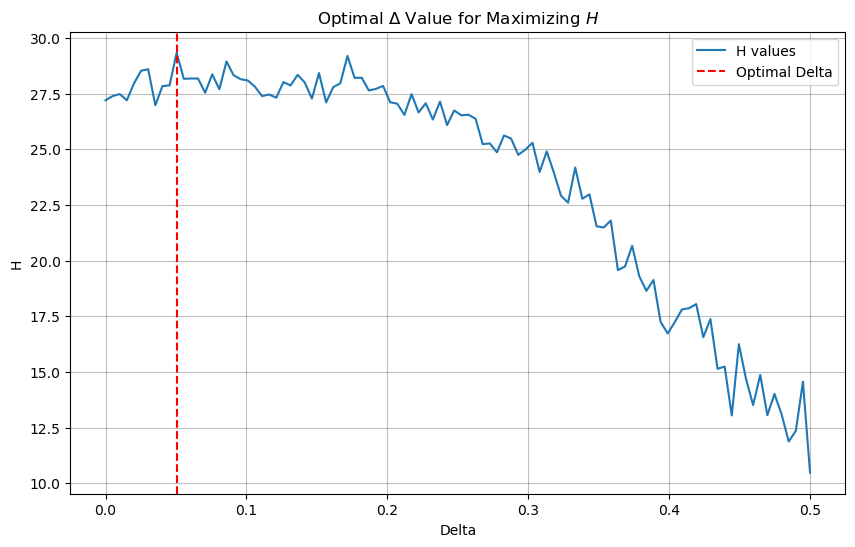

In [23]:
# Create figure
fig, ax = plt.subplots(figsize=(10,6))

# Plot x- and y-values
ax.plot(delta_vals, H_vals, label='H values')

# Plot a vertical line at the optimal delta
ax.axvline(x=optimal_delta, color='r', linestyle='--', label='Optimal Delta')

# Set labels, legend and title
ax.set_xlabel('Delta')
ax.set_ylabel('H')
ax.legend()
ax.set_title(fr'Optimal $\Delta$ Value for Maximizing $H$')

# Display plot
plt.show();

Since the function for $H$ is so rugged, I cannot give an exact answer, but the optimal $\Delta$, which maximizes $H$, appears to be between $0.05$ and $0.20$ depending on the seed.

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [24]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

Set-up of model:

In [25]:
# Set bounds
bounds = [-600, 600]

# Set tolerance for optimizer
tol = 1e-8

# Set warm-up and max iterations 
K_ = 10
K = 1000

Initialize refined multi-start optimizer:

In [26]:
# Initialize refined multi-start optimizer
def multi_start(tol = tol, bounds = bounds, K_ = K_, K = K, griewank = griewank, seed = 100):

    # Set seed
    np.random.seed(seed)
    
    # Set initial solutions
    x_star = np.nan
    fx_star = np.inf

    # Store initial x_k0
    x_k0s = []

    for k in range(K):
        # Draw two random numbers within bounds
        x_k = np.random.uniform(bounds[0], bounds[1], 2)
            
        # If k < warm-up iterations 
        if k < K_:
            # Set x_k0 to x_k and go to optimization
            x_k0 = x_k
        
        else:
            # Calculate chi^k
            chi_k = 0.50 * (2 / (1+np.exp((k - K_) / 100)))

            # Calculate x^k0
            x_k0 = chi_k * x_k + (1 - chi_k) * x_star

        x_k0s.append(x_k0)
        
        # Optimize the Griewank function for x_k0
        sol = optimize.minimize(fun = griewank, x0 = x_k0 , method = 'BFGS', tol = tol)

        # Store the optimizers solutions
        x_k_star = sol.x
        fx_k_star = sol.fun

        # Check if the current solution is better than the previous solution
        if k == 0 or fx_k_star < fx_star:
            x_star = x_k_star
            fx_star = fx_k_star

        # Stop if solution is less than tolerance
        if fx_star < tol:
            break
    
    return x_star, fx_star, k, x_k0s

I call the function ` multi_start` and illustrate how $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

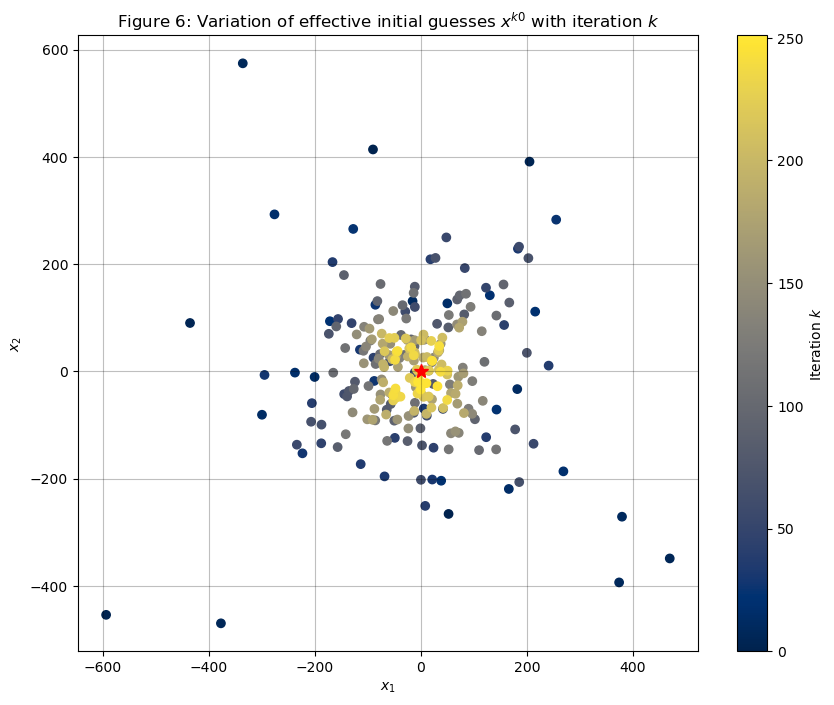

In [32]:
# Call the function
x_star, fx_star, k, x_k0s = multi_start(tol = tol, bounds = bounds, K_ = K_, K = K, griewank = griewank, seed = 100)

# Convert x_k0s to a numpy array
x_k0s = np.array(x_k0s)

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Create a scatter plot of all the initial guesses (x_k0s), color-coded by iteration number
scatter = ax.scatter(x_k0s[:, 0], x_k0s[:, 1], c=np.arange(len(x_k0s)), cmap='cividis')

# Plot the optimal solution (x_star) as a red star
ax.plot(x_star[0], x_star[1], 'r*', markersize=10)

# Set labels and title
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Figure 6: Variation of effective initial guesses $x^{k0}$ with iteration $k$')

# Create a colorbar
cbar = plt.colorbar(scatter, ax = ax)
cbar.set_label('Iteration $k$')

# Display plot
plt.show();

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

On average, the convergence seems slower for $\underline{K} = 100$, but sometimes it is faster since the initial guess may be closer to global minima. <br> 
Overall, the speed of convergence largely depends on the chosen seed. To illustrate this, I call the multi-start function with $\underline{K} = 10$ and $\underline{K} = 100$, and calculate the mean and standard deviation of $k$ given the optimal values for a range of seed values. 

Set up:

In [28]:
# Values of K_
K_s = [10, 100]

# Maximum seed
max_seed = 30

Calculate the number of iterations for $\underline{K} = 10$ and $\underline{K} = 100$ given the seed values; this requires much computation and might take a while. 

In [29]:
K_10_list = []
K_100_list = []

for seed in range(max_seed):
    # Call functions for the values of K_
    x_star_10, fx_star_10, k_10, x_k0s_10 = multi_start(tol = tol, bounds = bounds, K_ = K_s[0], K = K, griewank = griewank, seed = seed)

    x_star_100, fx_star_100, k_100, x_k0s_100 = multi_start(tol = tol, bounds = bounds, K_ = K_s[1], K = K, griewank = griewank, seed = seed)

    # Save iterations
    K_10_list.append(k_10)

    K_100_list.append(k_100)


Calclulate mean and standard deviation of $k$:

In [30]:
# Calculate mean and standard deviation for K_10
mean_K_10 = np.mean(K_10_list)
stddev_K_10 = np.std(K_10_list)

# Calculate mean and standard deviation for K_100
mean_K_100 = np.mean(K_100_list)
stddev_K_100 = np.std(K_100_list)

# Print values
print(f'For K_ = 10, mean = {mean_K_10:.2f} and std. dev. = {stddev_K_10:.2f}\n'
      f'For K_ = 100, mean = {mean_K_100:.2f} and std. dev. = {stddev_K_100:.2f}')

For K_ = 10, mean = 303.23 and std. dev. = 75.23
For K_ = 100, mean = 424.83 and std. dev. = 53.42


Plot histograms:

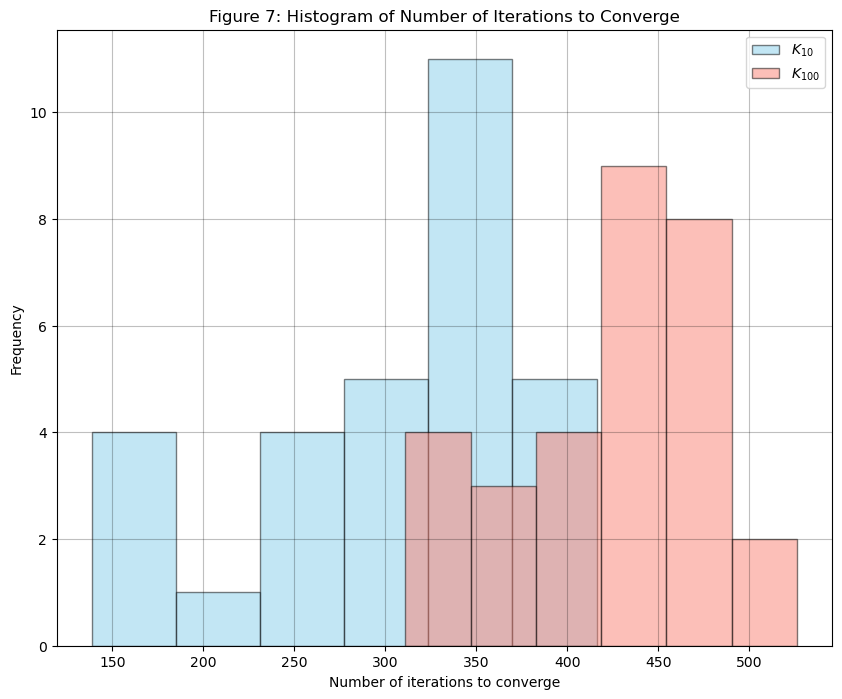

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot histograms
n_bins = 'fd'
ax.hist(K_10_list, bins = n_bins, alpha = 0.5, color = 'skyblue', edgecolor = 'black', label = r'$K_{10}$')
ax.hist(K_100_list, bins = n_bins, alpha = 0.5, color = 'salmon', edgecolor = 'black', label = r'$K_{100}$')

# Set labels and title
ax.set_xlabel('Number of iterations to converge')
ax.set_ylabel('Frequency')
ax.set_title('Figure 7: Histogram of Number of Iterations to Converge')
ax.legend(loc='upper right')

# Display plot
plt.show()


The statistics and histogram show some seed values where $\underline{K} = 100$ converges quicker than $\underline{K} = 10$, though generally, $\underline{K} = 10$ converges faster. This is only indicative, based on 30 seed values. Larger value plots are needed for more certainty but require significant computation.